In [ ]:
#for d2l
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install d2l==1.0.0b0xs

<h2>10.Modern_RNN</h2>

<h3>10.1. Long Short-Term Memory (LSTM)</h3>

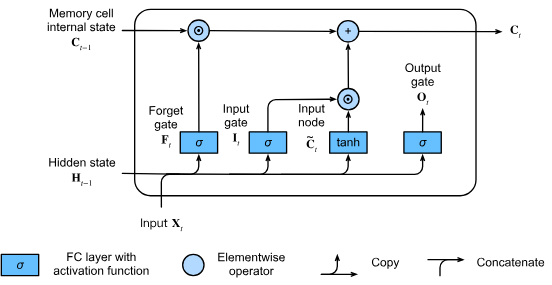

*   Exploding can be handled by gradient clipping, but vanishing isn't be solved. -> LSTM
*   long-term memory in the form of weights +  short-term memory in the form of ephemeral activations, which pass from each node to successive nodes

*  Input Gate, Forget Gate, Output Gate(with sigmoid)





In [6]:
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [8]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

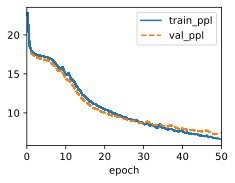

In [9]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

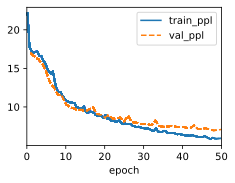

In [11]:
#Concise
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [10]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

<h3>10.2. Gated Recurrent Units (GRU)</h3>


In [12]:
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
...

Ellipsis